In [1]:
import jax 
import jax.numpy as jnp
from jax import grad, jit
from jax import random
import sys
import os
import optax
from matplotlib import pyplot as plt
import pickle

sys.path.append(os.path.abspath('../benchmarking/'))
from utils import *

sys.path.append(os.path.abspath('../blosum_construction/'))
from build_BLOSUM import *

## input data

In [2]:
data_path = "/cluster/tufts/pettilab/shared/structure_comparison_data"

# graph cluster assignments of blurry vectors; used to create starting centers
bv_path = f"{data_path}/graph_cluster_data/bv_subset_20000.npz"
true_label_path = f"{data_path}/graph_cluster_data/bv_subset_20000_labels.npy"

# ingredients for building all blurry vectors
nhot_path = f"{data_path}/blurry_vec/nHot.npz"
transition_mtx_path = f"{data_path}/blurry_vec/transition_mtx.npy"

# path of training pairs 
pairs_path = f"{data_path}/protein_data/pairs_training.csv"

## compute intial centers based on graph cluster assignments

In [3]:
bv_d = np.load(bv_path)
bvs = np.vstack([bv_d[str(i)] for i in range(len(bv_d.keys()))])
true_labels = np.load(true_label_path)
A = np.max(true_labels)

center_list = []
for t in range(A+1): 
    # Compute the median over the filtered rows (axis 0 computes the median across rows)
    center_list.append(np.median(bvs[true_labels == t], axis=0))
centers = jnp.stack(center_list)
print(centers.shape)                       
o_centers = jnp.array(centers)
bvs = None

(20, 1000)


## organize training pairs


In [4]:
nhot_d = dict(np.load(nhot_path))
for key in nhot_d.keys():
    nhot_d[key]= jnp.array(nhot_d[key]).astype(float)
# how long is each protein
name_to_length_d ={}
for key in nhot_d.keys():
    name_to_length_d[key]= nhot_d[key].shape[0]

In [5]:
# remove anything with 'd1e25a_' since we seem to be having some length issues the the alignment
# remove any pairs with length > 512 

pairs = []
alns_as_lists_d = {}

bad_list = ['d1e25a_','d1o7d.2','d1o7d.3']

first = True
with open(pairs_path, mode='r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        pair = (row[1],row[2])
        if first:
            first = False
            continue    
        elif pair[0] in bad_list or  pair[1] in bad_list:
            continue
        elif name_to_length_d[pair[0]]>512 or name_to_length_d[pair[1]]>512:
            continue
        else:
            pairs.append(pair)
            alns_as_lists_d[pair]= [int(i) for i in row[-1].strip('[]').split()]
print(len(pairs))

134147


In [6]:
%%time
# compute bvs for any protein that appears in a training pair
train_names = list({item for pair in pairs for item in pair})
print(len(train_names))
transition_mtx = np.load(transition_mtx_path)
bv_d = {}
for i, name in enumerate(train_names):
    bv_d[name] = jnp.einsum('ij,jk->ik', nhot_d[name],transition_mtx)
nhot_d  = {}

5496
CPU times: user 8.85 s, sys: 374 ms, total: 9.22 s
Wall time: 8.59 s


## compute MI on 20% of training pairs

In [7]:
# sort for better batching
n2l_d=name_to_length_d
pair_max_length_pairs = [(pair, max(n2l_d[pair[0]], n2l_d[pair[1]])) for pair in pairs]
sorted_keys = sorted(pair_max_length_pairs, key=lambda x: x[1])
sorted_pairs = [key for key, shape in sorted_keys]


In [8]:
def random_subsample(original_list, percentage=0.2):
    # Calculate the number of items to select
    num_to_select = max(1, int(len(original_list) * percentage))  # Ensure at least one item is selected
    
    # Randomly select indices
    np.random.seed(0)
    selected_indices = sorted(np.random.choice(range(len(original_list)), num_to_select))
    
    # Create the subsample based on selected indices
    subsample = [original_list[i] for i in selected_indices]
    return subsample

def compute_counts(pairs,oh_d, alns_as_lists, n2l_d, batch_size = 5000, save_path = None):
    jax.config.update("jax_enable_x64", True)
    counts = run_in_batches(pairs, oh_d, alns_as_lists, n2l_d, batch_size, verbose = False)
    return counts

def centers_to_alpha_d(centers, bv_d, b_names):
    alpha_d = {}
    for key in b_names:
        jaccard_with_each_center=jit_sim_mtx_blurry_from_blurry(bv_d[key][...,:-1], centers)
        alpha_d[key]=(jaccard_with_each_center == jnp.max(jaccard_with_each_center, axis=1, keepdims=True)).astype(int)
        #print(alpha_d[key].shape, jnp.sum(alpha_d[key]))
    return alpha_d

def MI_entropy_from_centers(centers):
    oh_d = centers_to_alpha_d(centers, bv_d, b_names)
    counts = compute_counts(b_pairs, oh_d, alns_as_lists_d, name_to_length_d)
    return jit_counts_to_MI(counts), jit_counts_to_entropy(counts)

In [9]:
b_pairs = random_subsample(sorted_pairs)
b_names = list({item for pair in b_pairs for item in pair})

print(len(pairs),len(b_pairs))
print(len(train_names), len(b_names))

134147 26829
5496 4695


## train it

In [10]:
@jit
def forward(centers, left_bvs, right_bvs, aln_lists, temp):
    """Computes counts for all alignment pairs"""
    centers = jnp.maximum(0,centers)
    # compute soft one-hot encodeings
    oh1 = jax.nn.softmax(v_sim_mtx_blurry_from_blurry(left_bvs, centers)*temp)
    oh2 = jax.nn.softmax(v_sim_mtx_blurry_from_blurry(right_bvs, centers)*temp)
    counts_by_pair = vv_compute_pairwise_counts(oh1, oh2, aln_lists)
    return jnp.sum(counts_by_pair, axis = 0)

@jit
def loss_fn(centers, left_bvs, right_bvs, aln_lists, temp, scale =1):
    """Computes MI of the matrix of counts"""
    counts = forward(centers, left_bvs, right_bvs, aln_lists, temp)
    # maximize MI
    #return jit_counts_to_entropy(counts)
    return -jit_counts_to_MI(counts) + jit_counts_to_entropy(counts)*scale


In [11]:
def plot(mat):
    a = np.max(np.abs(mat))
    plt.imshow(mat, vmin =-a, vmax = a, cmap = 'bwr' )
    plt.colorbar()
    plt.show()

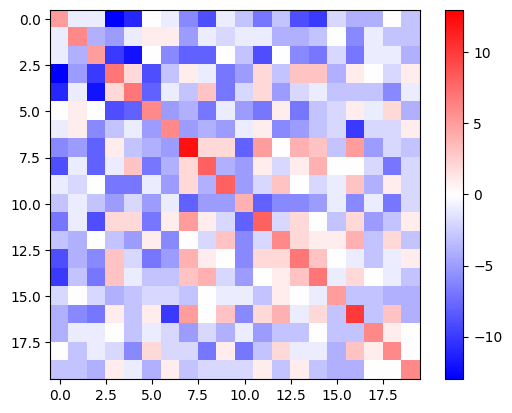

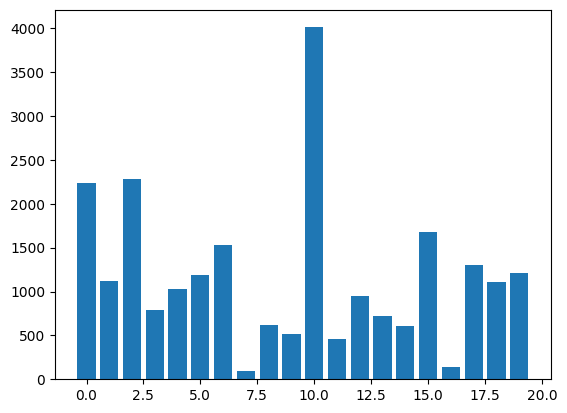

11800.136 11761
Epoch 0, loss: -3.6817, MI: 0.9098, EN: -2.7719, FMI: 1.0446, FEN: -2.7641 


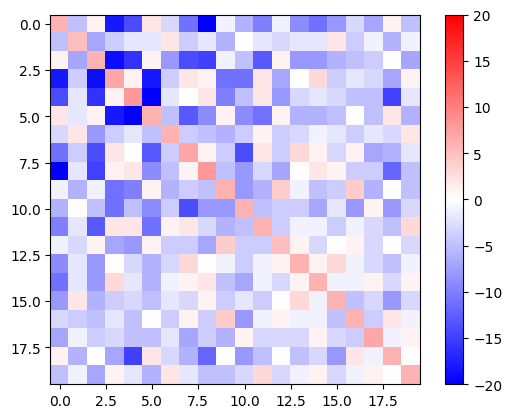

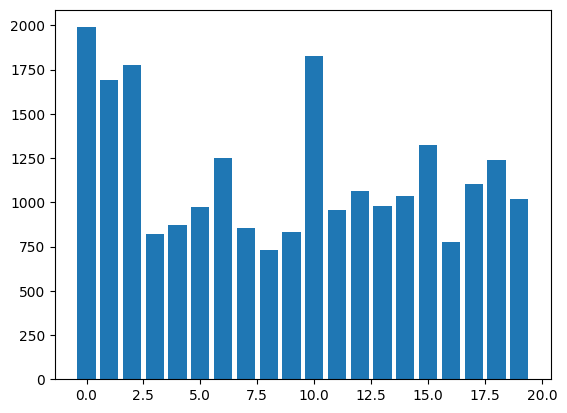

11561.104 11524
Epoch 50, loss: -4.2668, MI: 1.3155, EN: -2.9513, FMI: 1.4822, FEN: -2.9258 


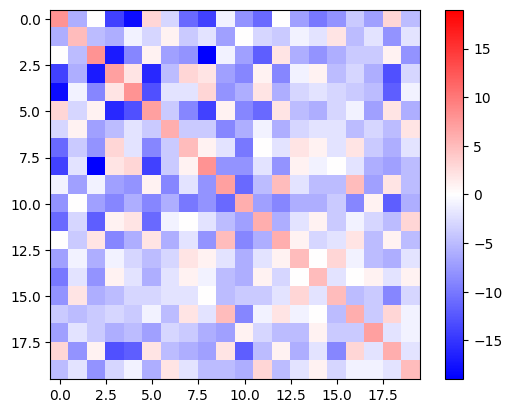

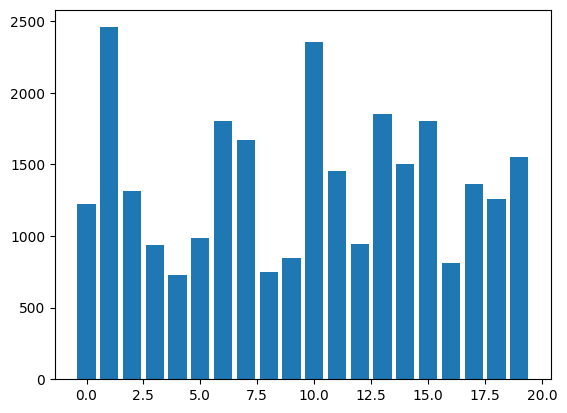

13800.049 13756
Epoch 100, loss: -4.3261, MI: 1.3890, EN: -2.9371, FMI: 1.6119, FEN: -2.9462 


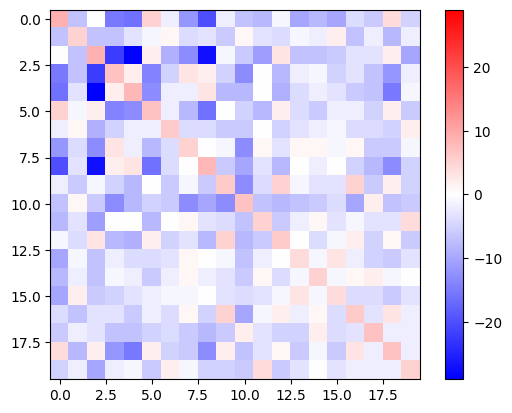

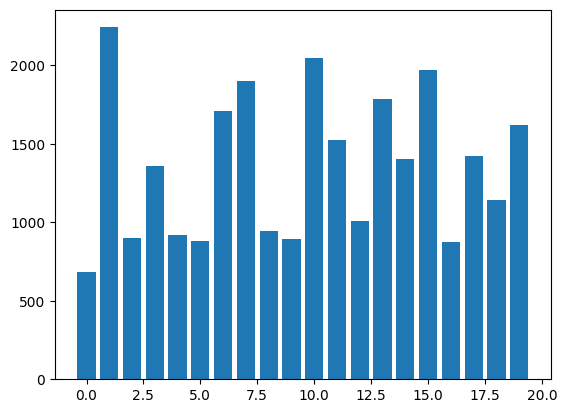

13620.036 13581
Epoch 150, loss: -4.3144, MI: 1.3721, EN: -2.9423, FMI: 1.6658, FEN: -2.9446 


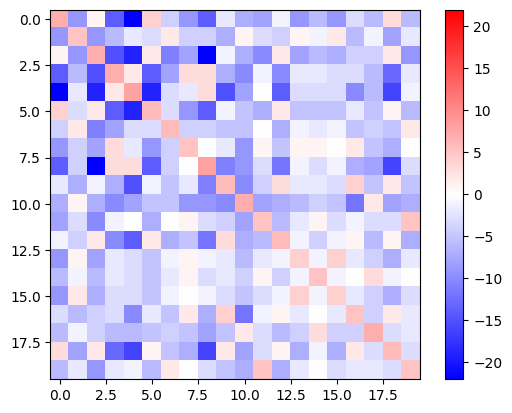

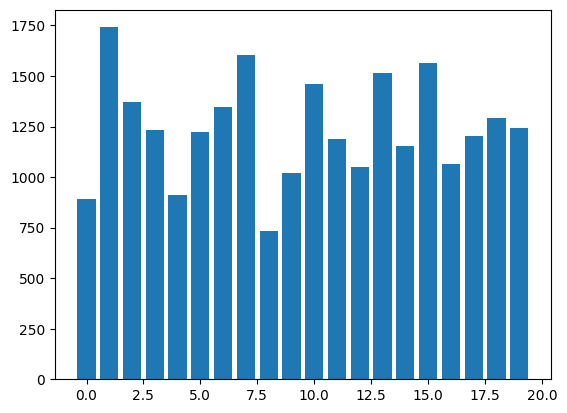

12407.001 12369
Epoch 200, loss: -4.4387, MI: 1.4624, EN: -2.9763, FMI: 1.6973, FEN: -2.9338 


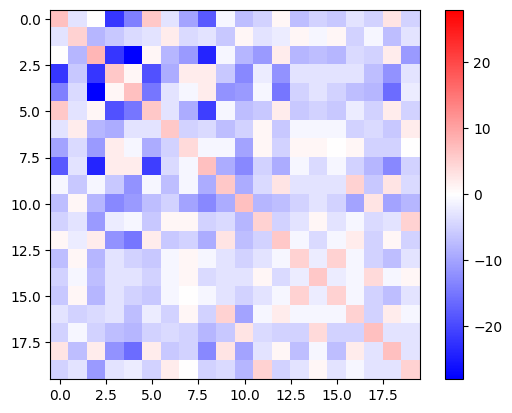

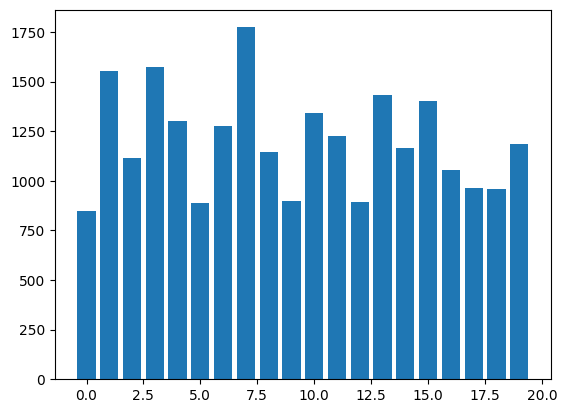

11997.039 11967
Epoch 250, loss: -4.5305, MI: 1.5552, EN: -2.9753, FMI: 1.6639, FEN: -2.8955 


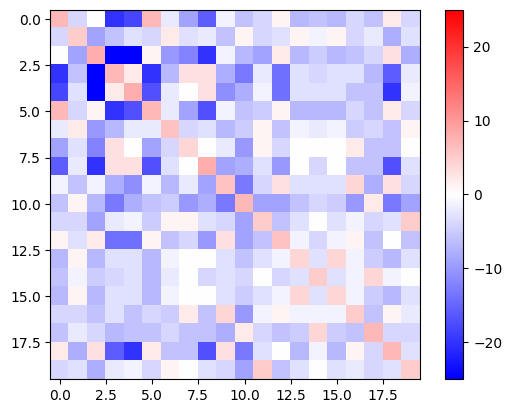

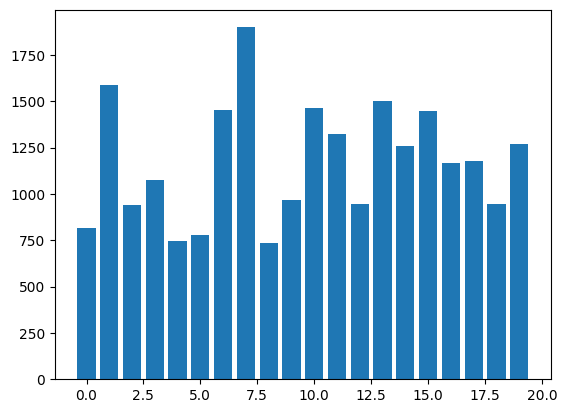

11746.018 11710
Epoch 300, loss: -4.4660, MI: 1.5031, EN: -2.9629, FMI: 1.6626, FEN: -2.8656 


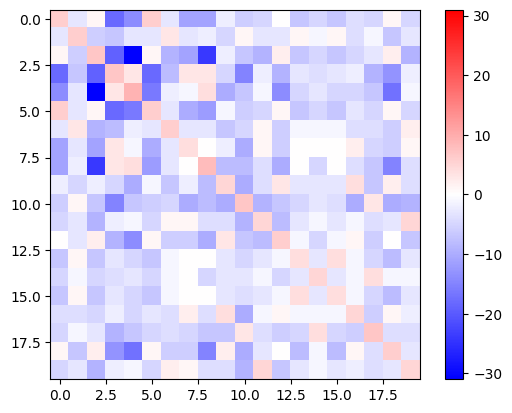

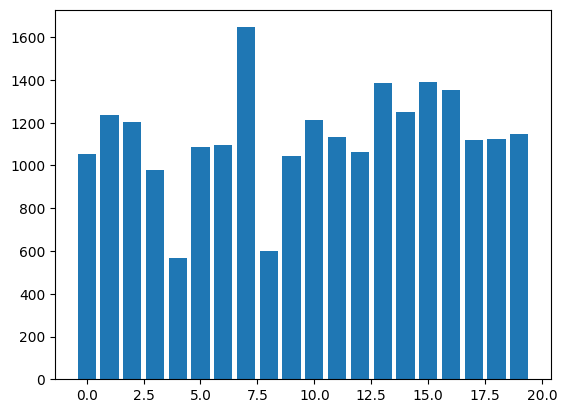

11341.01 11301
Epoch 350, loss: -4.4960, MI: 1.5224, EN: -2.9737, FMI: 1.6346, FEN: -2.8308 


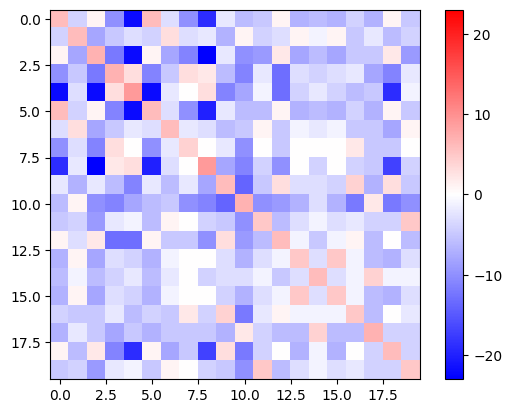

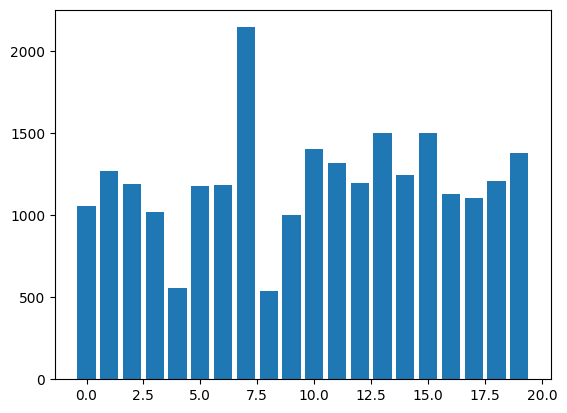

12056.011 12016
Epoch 400, loss: -4.5579, MI: 1.5969, EN: -2.9610, FMI: 1.5849, FEN: -2.7754 


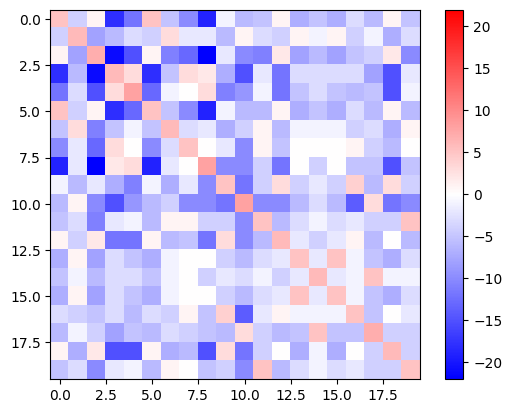

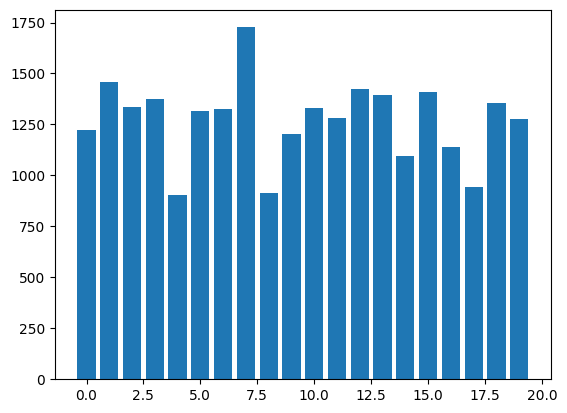

12717.02 12677
Epoch 450, loss: -4.6281, MI: 1.6436, EN: -2.9845, FMI: 1.5786, FEN: -2.7782 


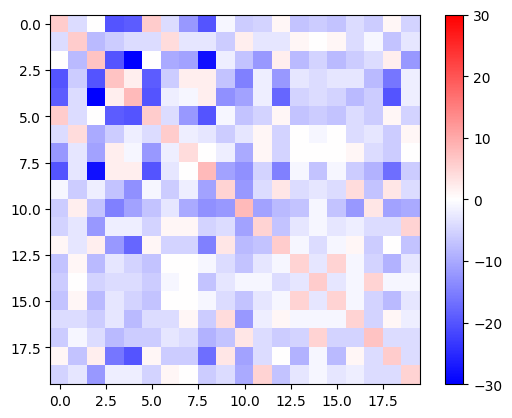

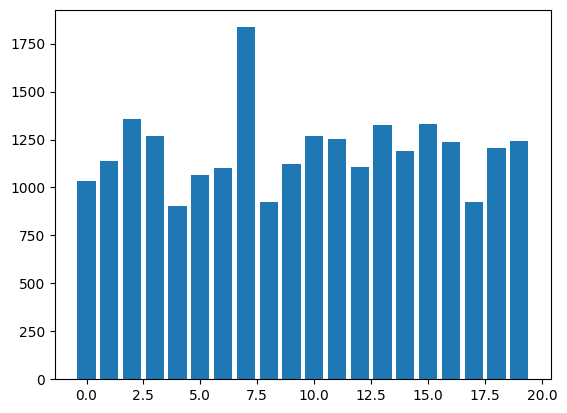

11922.988 11892
Epoch 500, loss: -4.6765, MI: 1.6931, EN: -2.9834, FMI: 1.5994, FEN: -2.7798 
CPU times: user 7min 9s, sys: 1min 28s, total: 8min 37s
Wall time: 6min 48s


In [12]:
%%time
key = random.PRNGKey(0) # sample random examples
batch_size = 100
num_epochs = 501
centers = o_centers
temp = 100
scale = 1/20
ls = []
mi =[]
en = []
full_mi = []
full_en = []
list_of_centers = []

# Train the model
start_learning_rate = 1e-3
optimizer = optax.adam(start_learning_rate)
opt_state = optimizer.init(centers)

# Train the model

    
start_learning_rate = 1e-3
optimizer = optax.adam(start_learning_rate)
opt_state = optimizer.init(centers)

for epoch in range(num_epochs):

    ### PROCESS BATCH
    
    # select random pairs
    key, subkey = jax.random.split(key)
    idx = jax.random.choice(subkey, len(pairs), shape=(batch_size,), replace=False)

    # compute max length of any protein
    batch_pairs = [pairs[i] for i in idx]
    names=[item for tup in batch_pairs for item in tup]
    max_len = max([name_to_length_d[name] for name in names])
    pad_to = int(jnp.where(max_len < 1, 1, 2 ** jnp.ceil(jnp.log2(max_len))))
    #print(pad_to)   

    # get aln_lists for batch, padded
    batch_alns = []
    for pair in batch_pairs:
        alnL=alns_as_lists_d[pair]
        batch_alns.append(jnp.pad(jnp.array(alnL),(0,pad_to-len(alnL)),constant_values =-1))
    batch_alns = jnp.stack(batch_alns)

    #compute left and right bvs
    lefts, _ = pad_and_stack_manual([bv_d[pair[0]] for pair in batch_pairs], pad_to = pad_to)
    rights, _ = pad_and_stack_manual([bv_d[pair[1]] for pair in batch_pairs], pad_to = pad_to)

    # get rid of -1 bin
    lefts = lefts[...,:-1]
    rights = rights[...,:-1]

    
    ### OPTIMIZE
    grads = grad(loss_fn)(centers, lefts, rights, batch_alns, temp, scale)
    updates, opt_state = optimizer.update(grads, opt_state)
    centers = optax.apply_updates(centers, updates)
        
    ### PRINT
    if epoch % 50 == 0:
        train_loss = loss_fn(centers, lefts, rights, batch_alns, temp)
        counts = forward(centers, lefts, rights, batch_alns, temp)
        
        # plot
        plot(counts_to_blosum(counts))
        plt.bar(range(counts.shape[0]),jnp.sum(counts, axis=0) + jnp.sum(counts, axis=1))
        plt.show()
        print(jnp.sum(counts), jnp.sum(batch_alns>0))
        
        #record
        fmi, fen = MI_entropy_from_centers(centers)
        full_mi.append(fmi)
        full_en.append(fen)
        ls.append(train_loss)
        en.append(jit_counts_to_entropy(counts))
        mi.append(jit_counts_to_MI(counts)) 
        list_of_centers.append(centers)
        print(f"Epoch {epoch}, loss: {train_loss:.4f}, MI: {mi[-1]:.4f}, EN: {en[-1]:.4f}, FMI: {full_mi[-1]:.4f}, FEN: {full_en[-1]:.4f} ")
        
    

## visualize results and pick centers with highest MI

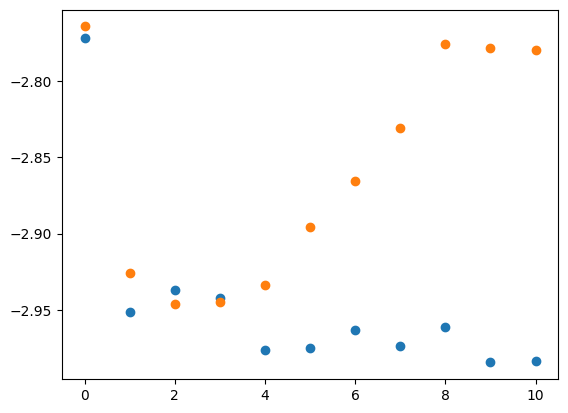

In [13]:
plt.scatter(range(len(en)), en, label="batch entropy")
plt.scatter(range(len(full_en)), full_en, label="20% entropy")

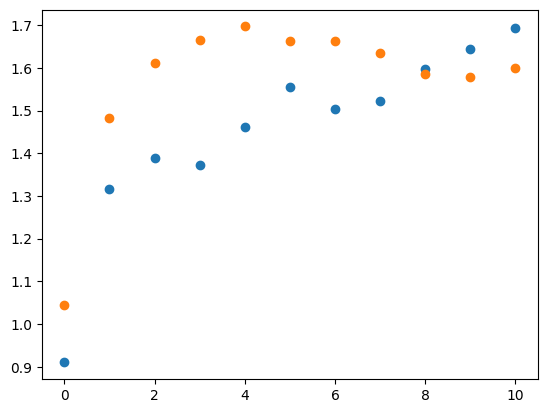

In [14]:
plt.scatter(range(len(mi)),mi,label="batch MI")
plt.scatter(range(len(full_mi)),full_mi, label="20% MI")

In [15]:
np.argmax(full_mi)

np.int64(4)

In [16]:
rounded_centers = np.maximum(0,list_of_centers[4])

In [17]:
np.save(f"{data_path}/graph_cluster_data/MI_centers.npy", rounded_centers)

## encode all sequences in this alphabet

In [3]:
%%time
nhot_d = np.load(nhot_path)
transition_mtx = np.load(transition_mtx_path)
centers = np.load(f"{data_path}/graph_cluster_data/MI_centers.npy")
alpha_d ={}
for key in list(nhot_d.keys()):
    if key == "d1o7d.2" or key == "d1o7d.3": continue
    nhot=nhot_d[key]
    bv =jnp.einsum('ik,kj->ij', nhot, transition_mtx)[:,:-1]
    jaccard_with_each_center=jit_sim_mtx_blurry_from_blurry(bv, centers)
    alpha_d[key]=(jaccard_with_each_center == jnp.max(jaccard_with_each_center, axis=1, keepdims=True)).astype(int)
np.savez(f'{data_path}/alphabets/MI.npz', **alpha_d)

CPU times: user 1h 21min 55s, sys: 52.9 s, total: 1h 22min 48s
Wall time: 15min 12s
